In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import zipfile
import os
from tqdm import tqdm

In [15]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantvillage-dataset


In [16]:
import os
import shutil
import random
from pathlib import Path

# Define source and destination directories
source_dir = '/kaggle/input/plantvillage-dataset/color'
dest_dir = '/kaggle/working/plantvillage-balanced'

# Create destination directory
os.makedirs(dest_dir, exist_ok=True)

# Step 1: Get all classes (folders) and image counts
class_counts = {}
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(image_files)

# Step 2: Determine the minimum number of images
min_count = min(class_counts.values())
print("Minimum number of images in any class:", min_count)

# Step 3: Downsample each class and copy to destination
for class_name in class_counts:
    src_class_path = os.path.join(source_dir, class_name)
    dst_class_path = os.path.join(dest_dir, class_name)
    os.makedirs(dst_class_path, exist_ok=True)

    image_files = [f for f in os.listdir(src_class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    sampled_files = random.sample(image_files, min_count)

    for filename in sampled_files:
        src = os.path.join(src_class_path, filename)
        dst = os.path.join(dst_class_path, filename)
        shutil.copy2(src, dst)

print("Balanced dataset created at:", dest_dir)


Minimum number of images in any class: 152
Balanced dataset created at: /kaggle/working/plantvillage-balanced


In [17]:


transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),      # Resize and crop for augmentation
    transforms.RandomHorizontalFlip(),      # Augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
dataset = datasets.ImageFolder(root="/kaggle/working/plantvillage-balanced", transform=transform_train)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply test transformation to validation and test sets

val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = dataset.classes
num_classes = len(class_names)

In [18]:
class_names = dataset.classes
num_classes = len(class_names)

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Output shape: [batch, 256, 1, 1]
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),          # [batch, 256]
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [20]:
class EarlyStopping:

    def __init__(self, patience=5):

        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf

    def check_early_stop(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [21]:


from tqdm import tqdm  # Import tqdm for progress bars
from torch.cuda.amp import autocast, GradScaler  # Import AMP utilities

# Set number of epochs and initialize variables

num_epochs = 50  # Define the number of training epochs

model = CustomCNN(num_classes=num_classes).to('cuda')  # Move model to GPU

criterion = nn.CrossEntropyLoss()  # Loss function

optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer with learning rate

early_stopping = EarlyStopping(patience=5)  # Initialize early stopping with patience

train_losses, val_losses = [], []  # Lists to store training and validation losses per epoch

# Initialize GradScaler for AMP
scaler = GradScaler()
# Loop over epochs
for epoch in range(num_epochs):

    print(f"Epoch {epoch+1}/{num_epochs}")
    # Training phase
    model.train()  # Set model to training mode
    train_loss = 0  # Initialize cumulative training loss for the epoch
    # Loop over training data with tqdm progress bar
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU
        optimizer.zero_grad()  # Clear previous gradients
        with autocast():  # Use AMP for mixed-precision calculations
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

        # Scale loss to avoid underflow for float16
        scaler.scale(loss).backward()  # Backward pass with scaled loss
        scaler.step(optimizer)  # Optimizer step
        scaler.update()  # Update the scaler for next iteration
        train_loss += loss.item()  # Accumulate the training loss

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0  # Initialize cumulative validation loss for the epoch
    with torch.no_grad():  # Disable gradient calculation for validation
        # Loop over validation data with tqdm progress bar
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU
            with autocast():  # Use AMP for mixed-precision calculations
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
            val_loss += loss.item()  # Accumulate the validation loss

    # Calculate average losses and append to lists
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Early stopping check
    if early_stopping.check_early_stop(avg_val_loss):
        print("Early stopping triggered.")
        break



/tmp/ipykernel_36/386367400.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/50


Training:   0%|          | 0/228 [00:00<?, ?it/s]/tmp/ipykernel_36/386367400.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Use AMP for mixed-precision calculations
Validation:   0%|          | 0/66 [00:00<?, ?it/s]         /tmp/ipykernel_36/386367400.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Use AMP for mixed-precision calculations


Train Loss: 2.3801, Validation Loss: 1.7349
Epoch 2/50


Train Loss: 1.5418, Validation Loss: 1.3460
Epoch 3/50


Train Loss: 1.2857, Validation Loss: 1.1154
Epoch 4/50


Train Loss: 1.1003, Validation Loss: 0.9245
Epoch 5/50


Train Loss: 0.9856, Validation Loss: 0.7135
Epoch 6/50


Train Loss: 0.9048, Validation Loss: 0.6742
Epoch 7/50


Train Loss: 0.8282, Validation Loss: 0.6981
Epoch 8/50


Train Loss: 0.7671, Validation Loss: 0.5560
Epoch 9/50


Train Loss: 0.7188, Validation Loss: 0.6624
Epoch 10/50


Train Loss: 0.6951, Validation Loss: 0.6368
Epoch 11/50


Train Loss: 0.6326, Validation Loss: 0.5164
Epoch 12/50


Train Loss: 0.6220, Validation Loss: 0.5317
Epoch 13/50


Train Loss: 0.5956, Validation Loss: 0.3818
Epoch 14/50


Train Loss: 0.5263, Validation Loss: 0.3490
Epoch 15/50


Train Loss: 0.5358, Validation Loss: 0.4389
Epoch 16/50


Train Loss: 0.5093, Validation Loss: 0.3549
Epoch 17/50


Train Loss: 0.4693, Validation Loss: 0.3648
Epoch 18/50


Train Loss: 0.4480, Validation Loss: 0.3568
Epoch 19/50


Train Loss: 0.4422, Validation Loss: 0.5451
Early stopping triggered.


In [22]:
# Define a path for saving the model
model_save_path = "custom_cnn_model.pth"  # You can specify a different path or filename

# Save the model after training completes or early stopping is triggered
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to custom_cnn_model.pth


In [23]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        with autocast():
            outputs = model(images)
        preds = torch.argmax(outputs, dim=1)  # Get predicted class
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
report = classification_report(all_labels, all_preds, digits=4)
print("Classification Report:\n", report)


/tmp/ipykernel_36/2132857589.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Classification Report:
               precision    recall  f1-score   support

           0     0.7463    0.7812    0.7634        64
           1     0.4386    1.0000    0.6098        50
           2     0.9048    0.9268    0.9157        41
           3     0.7812    0.8197    0.8000        61
           4     0.8448    0.9608    0.8991        51
           5     0.9492    1.0000    0.9739        56
           6     0.6579    0.9804    0.7874        51
           7     0.9091    0.8511    0.8791        47
           8     0.9552    1.0000    0.9771        64
           9     0.7963    0.9149    0.8515        47
          10     0.9825    0.9825    0.9825        57
          11     0.8696    0.5970    0.7080        67
          12     0.6742    0.9836    0.8000        61
          13     1.0000    0.8421    0.9143        57
          14     0.7576    0.9615    0.8475        52
          15     0.9375    0.9836    0.9600        61
          16     0.8393    0.8704    0.8545        54
   

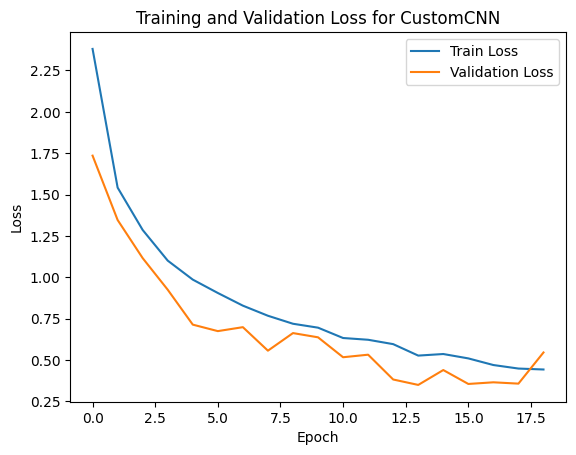

In [24]:
# Plotting loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss for CustomCNN")
plt.show()

In [31]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git




  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-bx0bh0ja
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-bx0bh0ja
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=43670 sha256=0fcf8b28c999f3296da8b05237c48191bed3bd14ec97543a226aa1fa8634b48f
  Stored in directory: /tmp/pip-ephem-wheel-cache-o8skdpd6/wheels/a0/4d/c8/0502c44e32030c99ffab1b98075308a1ef9829c1835537afc6
Successfully built grad-cam


In [32]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


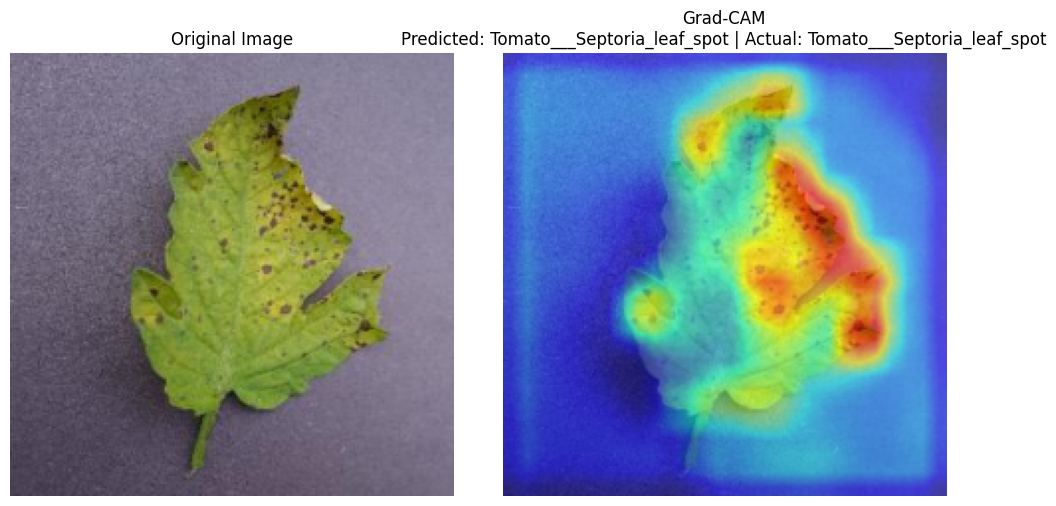

In [35]:
# Select sample image from test dataset
sample_image, label = test_dataset[0]
sample_image = sample_image.unsqueeze(0).to('cuda')  # Add batch dimension

# Prepare image for overlay (unnormalize)
original_image_np = sample_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
original_image_np = (original_image_np * 0.5) + 0.5  # Unnormalize
original_image_np = np.clip(original_image_np, 0, 1)

# Set target layer for Grad-CAM (adjust according to your model)
target_layers = [model.features[12]]  # Replace with the last conv layer in your CustomCNN

# Initialize Grad-CAM
gradcam = GradCAM(model=model, target_layers=target_layers)

# Get prediction
outputs = model(sample_image)
predicted_class = outputs.argmax().item()

# Create target for CAM
target = [ClassifierOutputTarget(predicted_class)]

# Generate Grad-CAM heatmap
heatmap = gradcam(input_tensor=sample_image, targets=target)[0]

# Overlay heatmap on original image
result = show_cam_on_image(original_image_np, heatmap, use_rgb=True)

# Plot original image and Grad-CAM result side by side
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image_np)
plt.axis('off')

# Grad-CAM result
plt.subplot(1, 2, 2)
plt.title(f"Grad-CAM\nPredicted: {class_names[predicted_class]} | Actual: {class_names[label]}")
plt.imshow(result)
plt.axis('off')

plt.tight_layout()
plt.show()